In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import make_grid
import os

import matplotlib.pyplot

In [28]:
paths=[] 
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input/imagenetmini-1000/imagenet-mini/train'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            paths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            labels+=[label]
            
tpaths=[]
tlabels=[]
for dirname, _, filenames in os.walk('/kaggle/input/imagenetmini-1000/imagenet-mini/val'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            tpaths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            tlabels+=[label]     

In [30]:
class_names=sorted(set(labels))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N))  

df=pd.DataFrame(columns=['path','label'])
df['path']=paths
df['label']=labels
df['label']=df['label'].map(normal_mapping)

tdf=pd.DataFrame(columns=['path','label'])
tdf['path']=tpaths
tdf['label']=tlabels
tdf['label']=tdf['label'].map(normal_mapping)

In [13]:
import random

class RandomResize:
    def __init__(self, min_size=256, max_size=512):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, img):
        width, height = img.size
        new_size = random.randint(self.min_size, self.max_size)
        
        if width < height:
            scale_factor = new_size / width
        else:
            scale_factor = new_size / height
        
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        
        return img.resize((new_width, new_height), Image.BILINEAR)

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        path = self.dataframe.loc[index, 'path']
        label = self.dataframe.loc[index, 'label']
        image = Image.open(path).convert('RGB')

        transform = transforms.Compose([
            
            transforms.RandomHorizontalFlip(),
            RandomResize(min_size=256, max_size=512),
            
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
            
            ])
        image = transform(image)
        return image, label

In [6]:
def train(model, optimizer, criterion, scheduler, train_loader, val_loader):
    history = dict()
    train_loss = []
    train_accuracy = []
    val_accuracy = []
    val_loss = []
    for i in range(10):
        epoch_train_loss = 0
        correct = 0
        total = 0
        for image, label in train_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            _, predicted = torch.max(output, 1)
            optimizer.zero_grad()
            loss = criterion(output, label)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            total += label.size(0)
            correct += (predicted == label).sum().item()

        epoch_train_accuracy = 100 * correct / total
        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        
        scheduler.step(epoch_train_accuracy)

        epoch_val_loss = 0
        correct = 0
        total = 0

        for image, label in val_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            loss = criterion(output, label)
            epoch_val_loss += loss.item()
            total += label.size(0)

            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()

        epoch_val_accuracy = 100 * correct / total
        val_accuracy.append(epoch_val_accuracy)
        val_loss.append(epoch_val_loss)

        print(f"Epoch {i+1}, Loss: {epoch_train_loss/len(train_loader)}, Accuracy: {epoch_train_accuracy}%, Loss: {epoch_val_loss/len(val_loader)}, Accuracy: {epoch_val_accuracy}%")
    history['train_loss'] = train_loss
    history['train_accuracy'] = train_accuracy
    history['val_accuracy'] = val_accuracy
    history['val_loss'] = val_loss
    
    return history, model
    
def plot(history):
    train_acc = history['train_accuracy']
    val_acc = history['val_accuracy']
    train_loss = history['train_loss']
    val_loss = history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
    ax1.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    ax2.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [59]:
train_ds=CustomDataset(df)
val_ds=CustomDataset(tdf)
train_loader=DataLoader(train_ds,batch_size=64,shuffle=True)
val_loader=DataLoader(val_ds,batch_size=64)

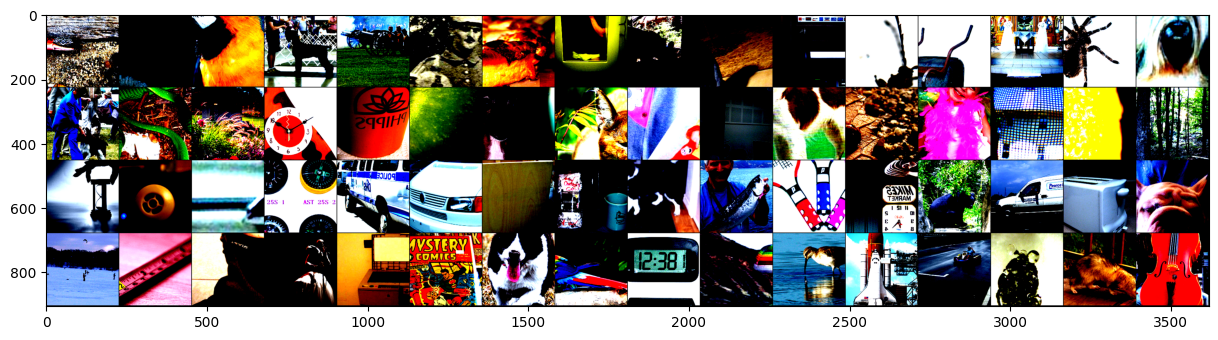

In [7]:
for images, labels in train_loader:
    break

im=make_grid(images,nrow=16)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [8]:
images[0].shape

torch.Size([3, 224, 224])

In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.vgg16 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.vgg16(x)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = VGG16().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True)

vgg_history, vgg = train(vgg16, optimizer, criterion, scheduler, train_loader, val_loader)

plot(vgg_history)

In [14]:
train_ds=CustomDataset(df[(df['label'] >= 0) & (df['label'] <= 199)].reset_index().drop('index', axis=1))
train_loader=DataLoader(train_ds,batch_size=64, shuffle=True)

val_ds=CustomDataset(tdf[(tdf['label'] >= 0) & (tdf['label'] <= 199)].reset_index().drop('index', axis=1))
val_loader=DataLoader(val_ds,batch_size=64)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_vgg = VGG16(num_classes=200).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(small_vgg.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True)

small_vgg_history, vgg = train(small_vgg, optimizer, criterion, scheduler, train_loader, val_loader)

plot(small_vgg_history)

In [15]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input/stanford-dogs-dataset/images/Images'):
    for filename in filenames:
        if filename[-3:]=='jpg':
            paths+=[(os.path.join(dirname, filename))]
            label=filename.split('_')[0]
            labels+=[label]
            
class_names=sorted(set(labels))
print(len(class_names))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 

df=pd.DataFrame(columns=['path','label'])
df['path']=paths
df['label']=labels
df['label']=df['label'].map(normal_mapping)

120


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label'])
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

train_ds = CustomDataset(X_train)

test_ds = CustomDataset(X_test)
train_loader=DataLoader(train_ds,batch_size=64,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dogVGG = VGG16(num_classes=120).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(dogVGG.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True)

dogVGG_history, vgg = train(dogVGG, optimizer, criterion, scheduler, train_loader, val_loader)

plot(dogVGG_history)

In [ ]:
from torchvision.models import vgg16, VGG16_Weights

class CustomVGG16(nn.Module):
    def __init__(self, num_classes=120):
        super(CustomVGG16, self).__init__()
        
        self.base_model = vgg16(weights=VGG16_Weights.DEFAULT)
        
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        self.base_model.classifier[6] = nn.Linear(self.base_model.classifier[6].in_features, num_classes)
        
    def forward(self, x):
        return self.base_model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_VGG16 = CustomVGG16(num_classes=120).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_VGG16.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True)

pretrained_VGG16_history, resnet50 = train(pretrained_VGG16, optimizer, criterion, scheduler, train_loader, val_loader)

plot(pretrained_VGG16_history)

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

class CustomResnet50(nn.Module):
    def __init__(self, num_classes=120):
        super(CustomResnet50, self).__init__()
        
        self.base_model = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        self.base_model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.base_model(x)
    
resnet50 = CustomResnet50(num_classes=120).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True)

resnet50_history, resnet50 = train(resnet50, optimizer, criterion, scheduler, train_loader, val_loader)

plot(resnet50_history)